In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.io import read_image
import torchvision.transforms as transforms
import time
import copy
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [2]:
classes = ('dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow')

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # Populate the img_labels list with tuples of image paths and labels
        for label_folder in os.listdir(img_dir):
            label_folder_path = os.path.join(img_dir, label_folder)
            if os.path.isdir(label_folder_path):
                for img_file in os.listdir(label_folder_path):
                    self.img_labels.append((os.path.join(label_folder, img_file), label_folder))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        full_img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(full_img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        label = classes.index(label)
        label = torch.tensor(label)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [4]:
# Define your transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),          # Resize the image to 256x256 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
    transforms.RandomRotation(10),          # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),                  # Convert the image to a PyTorch tensor
])


# Create the dataset
dataset = CustomImageDataset(img_dir='D:/Sem 6 Datasets/archive (2)/dataset', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(0.2 * len(dataset))

trainset, testset,valset, _ = torch.utils.data.random_split(dataset, [train_size,test_size, val_size,  len(dataset)-train_size-test_size-val_size])



# Create a DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
valloader = DataLoader(valset, batch_size=32, shuffle=False)

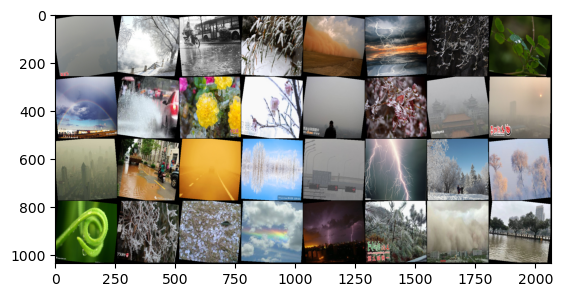

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

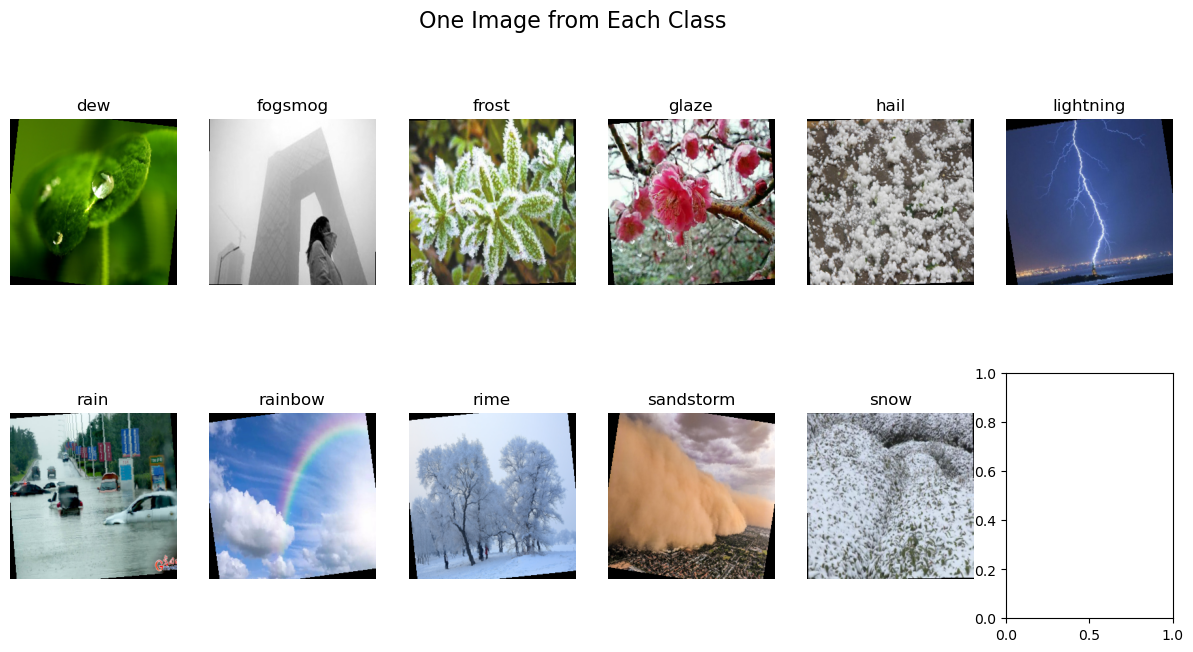

In [6]:
# Create a dictionary to store one image from each class
class_images = {class_name: None for class_name in classes}

# Find one image from each class
for data, target in dataset:
    if class_images[classes[target]] is None:
        class_images[classes[target]] = data
    if all(image is not None for image in class_images.values()):
        break

# Plot one image from each class
fig, axs = plt.subplots(2, 6, figsize=(15, 7))
fig.suptitle('One Image from Each Class', fontsize=16)

for i, (class_name, image) in enumerate(class_images.items()):
    row, col = divmod(i, 6)
    axs[row, col].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axs[row, col].set_title(class_name)
    axs[row, col].axis('off')

plt.show()

In [7]:
# 1. Modify ResNet Model for Fine-Tuning
class ResNetFineTuner(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFineTuner, self).__init__()
        # Load the pretrained ResNet model
        self.resnet = models.resnet101(weights='ResNet101_Weights.IMAGENET1K_V1')
        # Replace the last fully connected layer with a new one
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [8]:
# Initialize the fine-tuner
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 11
fine_tuner = ResNetFineTuner(num_classes).to(device)

In [9]:
def fine_tune_model(model, train_loader, val_loader, model_save_path,learning_rate=0.01, num_epochs=10, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience//2, verbose=True)

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_stats = -1

    # Lists to store metrics
    train_accuracies = []
    train_f1_scores = []
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        total_e_loss = 0
        num_batches = 0
        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_e_loss = loss.item() + total_e_loss
            num_batches = num_batches + 1
            loss.backward()
            optimizer.step()
        
        e_loss = total_e_loss / num_batches
        train_losses.append(e_loss)
        # Evaluation
        model.eval()  # Set model to evaluation mode
        train_labels = []
        train_preds = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Evaluation on validation data
        val_loss = 0
        val_labels = []
        val_preds = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        
        ##
        clear_output()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {e_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}')
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_stats = [train_accuracy, train_f1, val_accuracy, val_f1]
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
                
        # Plotting
        epochs_range = range(1, epoch + 2)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_f1_scores, label='Training F1 Score')
        plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, label='Training Loss')
        plt.plot(epochs_range, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    return best_model_stats

Epoch [10/10], Loss: 0.2651, Train Accuracy: 0.9242, Train F1: 0.9243, Validation Accuracy: 0.8827, Validation F1: 0.8827


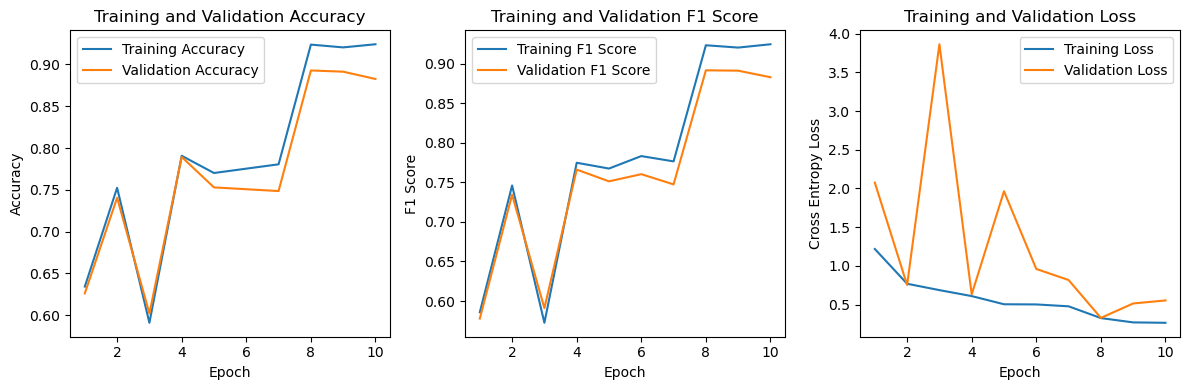

100%|██████████| 10/10 [4:15:05<00:00, 1530.53s/it]


In [10]:
# Fine-tune the model
learning_rate = 0.001
num_epochs = 10
patience=5
model_save_path = 'model.pth'
best_model_stats = fine_tune_model(fine_tuner, trainloader, valloader, learning_rate=learning_rate,
                num_epochs=num_epochs, patience=patience, model_save_path=model_save_path)

In [11]:
def get_labels(dataloader):
    labelsl = []
    for _, labels in dataloader:
        labelsl.extend(labels.cpu().detach().numpy())
        
    return labelsl

In [12]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

labels = get_labels(trainloader)
labels_val = get_labels(valloader)
labels_test = get_labels(testloader)

In [13]:
def get_model_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode

    predictions = []
    with torch.no_grad():  # No need to track gradients
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

In [14]:
def generate_accuracy_report(ground_truth, predictions):
    report = classification_report(ground_truth, predictions, digits=4)
    return report

In [15]:
## load best model state
# Load the state dictionary
state_dict = torch.load(model_save_path)
print('Loaded Model With Stats', best_model_stats)
# Update the model's state dictionary
fine_tuner.load_state_dict(state_dict)

Loaded Model With Stats [0.9237976264834479, 0.92309880244821, 0.8928571428571429, 0.8914555065602728]


<All keys matched successfully>

In [16]:
train_preds_p1 = get_model_predictions(fine_tuner, trainloader)
cross_val_preds_p1 = get_model_predictions(fine_tuner, valloader)
test_preds_p1 = get_model_predictions(fine_tuner, testloader)


# Evaluate on train data
train_report_p1 = generate_accuracy_report(labels, train_preds_p1)
print("Train Data Classification Report:\n", train_report_p1)

# Evaluate on cross-validation data
cross_val_report_p1 = generate_accuracy_report(labels_val, cross_val_preds_p1)
print("Cross-validation Data Classification Report:\n", cross_val_report_p1)

# Evaluate on test data
test_report_p1 = generate_accuracy_report(labels_test, test_preds_p1)
print("Test Data Classification Report:\n", test_report_p1)

Train Data Classification Report:
               precision    recall  f1-score   support

           0     0.9484    0.9841    0.9659       504
           1     0.9377    0.9751    0.9560       602
           2     0.9180    0.8023    0.8563       349
           3     0.8498    0.8536    0.8517       444
           4     0.9506    0.9688    0.9596       417
           5     0.9926    0.9963    0.9945       271
           6     0.9484    0.9357    0.9420       373
           7     0.9939    0.9880    0.9909       166
           8     0.8735    0.9409    0.9059       778
           9     0.9692    0.9484    0.9587       465
          10     0.9211    0.8065    0.8600       434

    accuracy                         0.9269      4803
   macro avg     0.9367    0.9272    0.9310      4803
weighted avg     0.9274    0.9269    0.9262      4803

Cross-validation Data Classification Report:
               precision    recall  f1-score   support

           0     0.9612    0.9688    0.9650       1

In [17]:
# 2. Feature Extraction (after fine-tuning)
# Remove the last fully connected layer
fine_tuner.resnet.fc = nn.Identity()

In [1]:
def extract_features(dataloader, model):
    features = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Flatten the output features
        outputs = outputs.view(outputs.size(0), -1)
        features.append(outputs.cpu().detach().numpy())
    return np.concatenate(features, axis=0)

In [ ]:
# Extract features
train_features = extract_features(trainloader, fine_tuner)
cross_features = extract_features(valloader, fine_tuner)
test_features = extract_features(testloader, fine_tuner)

In [ ]:
# Encode labels if they are not already in the format 0, 1, 2, ...
label_encoder = LabelEncoder()
label_encoder.fit(labels)
encoded_labels = np.array(label_encoder.transform(labels))
encoded_labels_val = np.array(label_encoder.transform(labels_val))
encoded_labels_test = np.array(label_encoder.transform(labels_test))

In [ ]:
# Define the parameter grid,.. to-do : add more parameters
param_grid = {
    'max_depth': [3,10],
    'learning_rate': [0.1],
    'n_estimators': [2000, 5000],
    'reg_lambda': [1,2],  
    
}

# Create a xgb model
model = xgb.XGBClassifier(device="cuda", objective='multi:softmax', num_class=11)

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features, encoded_labels)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

In [5]:
def evaluate_model(classifier, features, true_labels):
    predictions = classifier.predict(features)
    return classification_report(true_labels, predictions, digits=4), predictions

In [ ]:
grid_search.best_params_

In [ ]:
model = xgb.XGBClassifier(device="cuda", objective='multi:softmax', num_class=11, **grid_search.best_params_)
model.fit(train_features, encoded_labels)

# Evaluate on train data
train_report_p2, train_preds_p2 = evaluate_model(model, train_features, encoded_labels)
print("Train Data Classification Report:\n", train_report_p2)

# Evaluate on cross-validation data
cross_val_report_p2, cross_val_preds_p2 = evaluate_model(model, cross_features, encoded_labels_val)
print("Cross-validation Data Classification Report:\n", cross_val_report_p2)

# Evaluate on test data
test_report_p2,test_preds_p2  = evaluate_model(model, test_features, encoded_labels_test)
print("Test Data Classification Report:\n", test_report_p2)

In [ ]:
class GeneticMutationOptimizer:
    def __init__(self, population_size=50, mutation_rate=0.005, crossover_rate=0.5, num_generations=5, num_features=2048):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.num_features = num_features

    def initialize_population(self):
#         return np.random.randint(2, size=(self.population_size, self.num_features))
        return np.ones((self.population_size, self.num_features))
    
    def fitness(self, individual, features, labels, model, features_val, labels_val):
        # Extract the features based on the individual's gene
        selected_features = features[:, individual == 1]
        selected_features_val = features_val[:, individual == 1]
#         print(f"selecting {selected_features.shape[1]} features")
        # Train and evaluate the model using these features
        model.fit(selected_features, labels)
        predictions = model.predict(selected_features_val)
        f1_weighted_score = f1_score(labels_val, predictions, average='weighted')

        return f1_weighted_score

    def select(self, population, fitness_scores):
        # Perform selection based on fitness scores
        parents = np.random.choice(np.arange(self.population_size), size=self.population_size, replace=True, p=fitness_scores/fitness_scores.sum())
        return population[parents]

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.num_features)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        else:
            child = parent1.copy()
        return child

    def mutate(self, individual):
        for i in range(self.num_features):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def optimize(self, features, labels, model, features_val, labels_val):
        population = self.initialize_population()
        best_individual = None
        best_fitness = 0

        for generation in tqdm(range(self.num_generations)):
            fitness_scores = np.array([self.fitness(individual, features, labels, model, features_val, labels_val) for individual in population])
            best_generation_fitness = np.max(fitness_scores)
            if best_generation_fitness > best_fitness:
                best_fitness = best_generation_fitness
                best_individual = population[np.argmax(fitness_scores)].copy()
            
            print("best fitness so far", best_fitness)
            
            selected = self.select(population, fitness_scores)
            population = np.array([self.crossover(selected[np.random.randint(self.population_size)], selected[np.random.randint(self.population_size)]) for _ in range(self.population_size)])
            population = np.array([self.mutate(individual) for individual in population])

        return best_individual

In [ ]:
# classifier = svm.SVC()
classifier = xgb.XGBClassifier(**grid_search.best_params_,device="cuda", objective='multi:softmax', num_class=11)
# classifier = KNeighborsClassifier(n_neighbors=4)

genetic_optimizer = GeneticMutationOptimizer(num_features=2048)
selected_features_idx = genetic_optimizer.optimize(train_features, encoded_labels, classifier, cross_features, encoded_labels_val)

In [ ]:
len(selected_features_idx[selected_features_idx == 1])

In [ ]:
# Select features based on the indices from the optimizer
selected_train_features = train_features[:, selected_features_idx==1]
selected_cross_features = cross_features[:, selected_features_idx==1]
selected_test_features = test_features[:, selected_features_idx==1]

In [ ]:
# Train the classifier
classifier.fit(selected_train_features, encoded_labels)

# Evaluate on train data
train_report_p3, train_preds_p3 = evaluate_model(classifier, selected_train_features, encoded_labels)
print("Train Data Classification Report:\n", train_report_p3)

# Evaluate on cross-validation data
cross_val_report_p3, cross_val_preds_p3 = evaluate_model(classifier, selected_cross_features, encoded_labels_val)
print("Cross-validation Data Classification Report:\n", cross_val_report_p3)

# Evaluate on test data
test_report_p3, test_preds_p3 = evaluate_model(classifier, selected_test_features, encoded_labels_test)
print("Test Data Classification Report:\n", test_report_p3)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    return accuracy, f1_weighted

# Assuming you have the true labels as encoded_labels, encoded_labels_val, encoded_labels_test
# Calculate metrics for train data
train_accuracy_p1, train_f1_weighted_p1 = calculate_metrics(encoded_labels, train_preds_p1)
train_accuracy_p2, train_f1_weighted_p2 = calculate_metrics(encoded_labels, train_preds_p2)
train_accuracy_p3, train_f1_weighted_p3 = calculate_metrics(encoded_labels, train_preds_p3)

# Calculate metrics for cross-validation data
cross_val_accuracy_p1, cross_val_f1_weighted_p1 = calculate_metrics(encoded_labels_val, cross_val_preds_p1)
cross_val_accuracy_p2, cross_val_f1_weighted_p2 = calculate_metrics(encoded_labels_val, cross_val_preds_p2)
cross_val_accuracy_p3, cross_val_f1_weighted_p3 = calculate_metrics(encoded_labels_val, cross_val_preds_p3)

# Calculate metrics for test data
test_accuracy_p1, test_f1_weighted_p1 = calculate_metrics(encoded_labels_test, test_preds_p1)
test_accuracy_p2, test_f1_weighted_p2 = calculate_metrics(encoded_labels_test, test_preds_p2)
test_accuracy_p3, test_f1_weighted_p3 = calculate_metrics(encoded_labels_test, test_preds_p3)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetics for Seaborn
sns.set_theme(style="whitegrid")

# Data for plotting
pipelines = ['DL + Classification', 'DL + XGBoost GS', 'DL + XGBoost + FS']
# Accuracy and F1-scores for each pipeline and dataset
train_accuracies = [train_accuracy_p1, train_accuracy_p2, train_accuracy_p3]
train_f1_scores = [train_f1_weighted_p1, train_f1_weighted_p2, train_f1_weighted_p3]
cross_val_accuracies = [cross_val_accuracy_p1, cross_val_accuracy_p2, cross_val_accuracy_p3]
cross_val_f1_scores = [cross_val_f1_weighted_p1, cross_val_f1_weighted_p2, cross_val_f1_weighted_p3]
test_accuracies = [test_accuracy_p1, test_accuracy_p2, test_accuracy_p3]
test_f1_scores = [test_f1_weighted_p1, test_f1_weighted_p2, test_f1_weighted_p3]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Performance Comparison Across Different Pipelines', fontsize=18)

def plot_bar(ax, metric_values, title, metric_name):
    """Plots a bar chart on the given axes."""
    sns.barplot(x=pipelines, y=metric_values, palette="viridis", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_xlabel('Pipeline', fontsize=14)
    ax.tick_params(labelsize=12)
    # Add the metric values on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# Plotting for each subplot
plot_bar(axes[0, 0], train_accuracies, 'Train Data - Accuracy', 'Accuracy')
plot_bar(axes[0, 1], train_f1_scores, 'Train Data - F1 Score (Weighted)', 'F1 Score (Weighted)')
plot_bar(axes[1, 0], cross_val_accuracies, 'Validation Data - Accuracy', 'Accuracy')
plot_bar(axes[1, 1], cross_val_f1_scores, 'Validation Data - F1 Score (Weighted)', 'F1 Score (Weighted)')
plot_bar(axes[2, 0], test_accuracies, 'Test Data - Accuracy', 'Accuracy')
plot_bar(axes[2, 1], test_f1_scores, 'Test Data - F1 Score (Weighted)', 'F1 Score (Weighted)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
plt.show()